In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
IN_CHANNELS = 1
N_CLASSES = 2
EPOCH =200

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### head

In [6]:
ACT = "softmax"
AUX_PARAM = None

### Optimizer Settings

In [7]:
OPTIM_NAME = "sgd"
init_lr = 3e-4
momentum = 0.9

# Epochs

In [8]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR

In [9]:
def train_epoch(model, optimizer, dataloader, device):
  
    # change mode to train and move to current device
    model = model.train().to(device)

    y_loss = 0
    x_loss = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y = data

        x = x.to(device)
        y = y.to(device)

        x_pr = model(x)
        y_pr = model(y)
        
        shape = x.size()[0]
        pr_one = torch.ones(shape, dtype=torch.long, device=device)
        pr_zero = torch.zeros(shape, dtype=torch.long, device=device)

        _x = nn.CrossEntropyLoss()(x_pr.float(), pr_zero)
        _y = nn.CrossEntropyLoss()(y_pr.float(), pr_one)
                          
        _loss = _y + _x
                        
        optimizer.zero_grad()
        _loss.backward()
        optimizer.step()

        y_loss += _y.item()
        x_loss += _x.item()

    return x_loss/(index+1), y_loss/(index+1) 

In [10]:
@torch.no_grad()
def eval_epoch(model, dataloader, device):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    total = 0
    cbct_hit = 0
    ct_hit = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y = data
        
        x = x.to(device)
        y = y.to(device)

        x_pr = model(x)
        y_pr = model(y)
        
        total += x.size()[0]
        shape = x.size()[0]
        pr_one = torch.ones(shape, dtype=torch.float, device=device)
        pr_zero = torch.zeros(shape, dtype=torch.float, device=device)
        
        _, x_pr = torch.max(x_pr.data, 1)
        cbct_hit += (x_pr == pr_zero).sum().item()
        _, y_pr = torch.max(y_pr.data, 1)
        ct_hit += (y_pr == pr_one).sum().item()
        

    return  cbct_hit/total, ct_hit/total

In [11]:
@torch.no_grad()
def test_epoch(model, dataloader, device):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    ssim = 0
    psnr = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y = data

        x = x.to(device)
        y = y.to(device)

        y_pr = model(x)

        x = x.squeeze().cpu().numpy()
        y = y.squeeze().cpu().numpy()
        y_pr = y_pr.squeeze().cpu().numpy() * 255
        y_pr = y_pr.astype(np.uint8)

        visualize(
            cbct = x,
            ct_y = y,
            ct_pred = y_pr,
        )

# Read Data

In [12]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [13]:
train_case_path = 'data/train/*_*'
test_case_path = 'data/test/*_*'

In [14]:
trainset = Dataset(path=train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, intensity_aug=aug.validation_intensity_augmentation(), geometry_aug=aug.get_validation_augmentation())

In [15]:
len(trainset), len(testset)

(1344, 191)

In [16]:
x, y = trainset[20]

(<matplotlib.image.AxesImage at 0x7f636ec38f40>,)

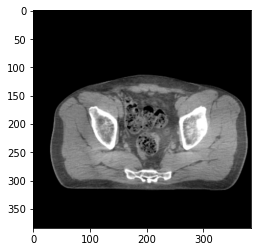

In [17]:
plt.imshow(x.squeeze(), 'gray'),

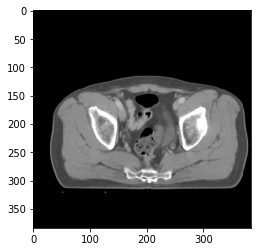

In [18]:
plt.imshow(y.squeeze(), 'gray')

In [19]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# Model

In [20]:
from codes.activation import Activation

In [21]:
class Model(nn.Module):
    def __init__(self, encoder, hidden_ch=2048, n_classes=2, activation=None):
        
        super(Model, self).__init__()
        
        self.encoder = encoder
        self.classifier = nn.Linear(in_features=hidden_ch, out_features=n_classes)
        self.pooling = nn.AdaptiveMaxPool2d(1)
        self.activation = Activation(name=activation)
        
        
    def forward(self, x):
        
        x = self.encoder(x)[-1]
        x = self.pooling(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        
        return self.activation(x)

# training

In [22]:
import wandb

wandb.init(project="discriminator", config={
    "data": {
        "in_channels": IN_CHANNELS,
        "out_channels": N_CLASSES,
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "optimizer": OPTIM_NAME,
        "init_lr": init_lr,
        "momentum": momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": ACT,
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [23]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [24]:
import segmentation_models_pytorch as smp
import torch

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=IN_CHANNELS, classes=N_CLASSES)

model = Model(encoder=model.encoder, hidden_ch=2048, n_classes=N_CLASSES, activation=ACT)

In [25]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
optimizer = Optimizer(model.parameters(), name=OPTIM_NAME, lr=init_lr)

In [ ]:
wandb.watch(model)

max_acc = 0

for epoch in range(EPOCH):
        
        loss_cbct, loss_ct = train_epoch(model, optimizer, trainloader, device)
        cbct_acc_train, ct_acc_train = eval_epoch(model, trainloader, device)
        cbct_acc_test, ct_acc_test = eval_epoch(model, testloader, device)

        
        wandb.log({
            "cbct bce loss": loss_cbct,
            "ct bce loss": loss_ct,
            "trainset cbct acc": cbct_acc_train,
            "trainset ct acc": ct_acc_train,
            "testset cbct acc": cbct_acc_test,
            "testset ct acc": ct_acc_test
        })
        
        
        if max_acc > cbct_acc_test + ct_acc_test:
            max_acc = cbct_acc_test + ct_acc_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("discriminator", "{}.pth".format(wandb.run.name)))

168it [02:20,  1.19it/s]
168it [00:41,  4.04it/s]
24it [00:06,  3.66it/s]
168it [02:19,  1.21it/s]
168it [00:45,  3.68it/s]
24it [00:06,  3.64it/s]
168it [02:20,  1.19it/s]
168it [00:41,  4.09it/s]
24it [00:06,  3.75it/s]
168it [02:20,  1.20it/s]
168it [00:41,  4.02it/s]
24it [00:06,  3.63it/s]
168it [02:21,  1.19it/s]
168it [00:45,  3.67it/s]
24it [00:06,  3.63it/s]
168it [02:23,  1.17it/s]
168it [00:44,  3.79it/s]
24it [00:06,  3.73it/s]
168it [03:14,  1.16s/it]
168it [01:03,  2.64it/s]
24it [00:09,  2.59it/s]
168it [03:24,  1.22s/it]
168it [01:01,  2.74it/s]
24it [00:09,  2.46it/s]
168it [03:25,  1.23s/it]
168it [01:06,  2.54it/s]
24it [00:09,  2.50it/s]
168it [03:30,  1.25s/it]
168it [01:06,  2.54it/s]
24it [00:09,  2.45it/s]
168it [03:29,  1.25s/it]
168it [01:07,  2.49it/s]
24it [00:06,  3.54it/s]
168it [03:34,  1.28s/it]
168it [01:04,  2.61it/s]
24it [00:08,  2.89it/s]
168it [03:31,  1.26s/it]
168it [01:06,  2.54it/s]
24it [00:09,  2.45it/s]
168it [03:24,  1.22s/it]
168it [01:08,